# Notebook 2
# Example of use astroABC package
## Roger Mor

### Multiprocessing in a normal PC

### Introduction to ABC

Approximate Bayesian computation
(ABC) and so called "likelihood free" Markov chain Monte Carlo techniques are popular methods
for tackling parameter inference in scenarios where the likelihood is intractable or unknown.
These methods are called likelihood free as they are free from any assumption about the form of the likelihood, as ABC aims to simulate samples from the parameter posterior distribution directly.
In traditional MCMC approaches the target distribution is the posterior distribution of interest and in practice our estimate of this pdf is approximate due to finite sampling time resulting in a correlated chain which we hope has converged.
ABC methods are also approximate in the sense that samples are generated from trial distributions which we hope are close to the real posterior of interest.
The [wikipedia]( https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) page on ABC has a good introduction to the topic.

The simplest ABC algorithm is rejection sampling. 
Given a set of parameters, $\theta$, with associated priors, $\pi(\theta)$ and a forward simulated model for the data,

$\pi(D|\theta)$. 

We can simulate from the posterior distribution, $P(\theta|D)$, by first drawing sample parameters

$\theta^* \sim \pi(\theta)$, 

then simulating a dataset with these parameters 

$D^* \sim \pi(D|\theta^*)$.

In a simple rejection sampling algorithm, we reject $D^*$  unless it matches the true data, $D$.
For discrete data this algorithm would not be practical as many simulated samples would be rejected until an exact match is found.
In practice we make an approximation and accept simulated datasets which are "close" to the true data. This introduces the idea of a distance metric and tolerance level in ABC. We accept proposed parameters $\theta^*$, if 

$\rho(D^* - D) <\epsilon$

where $\rho$ is the distance metric, which could be e.g. the Euclidean norm $||D^* - D||$,  and $\epsilon$ is a tolerance threshold. This procedure produces samples from 

$P(\theta | \rho(D^*-D)<\epsilon)$ 

which will be a good approximation of the true posterior if $\epsilon$ is small.

The tolerance threshold in ABC controls which of the proposed parameters are accepted given the distance metric. There are two considerations in choosing this threshold. If the tolerance is too high then too many proposed parameters are accepted and the prior distribution dominates the results e.g. if the tolerance level is infinity then we would just recover the prior distribution from the algorithm. If the tolerance level is too low then the sampler is very inefficient with many proposed points being rejected.
A compromise is to select a set of decreasing tolerance levels where for the initial iterations in the algorithm we accept points in parameter space which do not represent the data with high accuracy but as the algorithm progresses the tolerance level decreases and our estimate of the true posterior distribution improves.

In many cases it may be simpler to work with some lower dimension summary statistic of the data, $S(D)$,
rather then the full dataset. In this case the chosen statistic needs to be a so-called *sufficient statistic* in that
any information about the parameter of interest which is contained in the data, is also contained in the summary statistic. More formally a statistic $S(D)$ is sufficient for $\theta$ if the distribution $P(D|S(D))$ does not depend on $\theta$.
This requirement ensures that in summarizing the data we have not thrown away constraining information about $\theta$.


### ABC Sequential Monte Carlo

Rather than drawing candiates $\theta^*$, one at a time, we can
speed up the ABC algorithm by working with large
pools of candidates, called particles, simultaneously. 
At each stage of the algorithm the particles are perturbed and filtered using the distance metric, and eventually
this pool of particles move closer and closer to simulating from the desired posterior distribution.
This approach is known as Sequential Monte Carlo or Particle Monte Carlo sampling.

Outline of the ABC SMC algorithm:

- At iteration 0, for each particle:
    1. Generate $\theta_i^* \sim \pi(\theta)$. 
    2. Simulate a dataset $D_i^* \sim \pi(D|\theta_i^*)$
    3. If  $\rho(S(D_i^*) - S(D))<\epsilon_0$ accept $\theta_i^*$ else go to 1.
- set $\theta_{i,0} = \theta_i^*$
- set weights for each particle $w_{i,0} = 1/N$
- evaluate the covariance amongst particles $\sigma^2_{1:N;0}$
- At iteration t>0, for each particle: 
    4. Sample random particle from previous iteration $\theta_i^* \sim \theta_{1:N;0}$ 
    5. Perturb $\theta_i^*$ by drawing $\theta_i^{**} \sim \mathcal{N}(\theta^*, \sigma^2_{t-1})$
    6. Simulate a dataset $D_i^* \sim \pi(D|\theta_i^{**})$
    7. If  $\rho(S(D_i^*) - S(D))<\epsilon_0$ accept $\theta_i^{**}$ else go to 4.
- set $\theta_{i,t} = \theta_i^{**}$
- set weights for each particle $w_{i,t}$ using a transition kernel
- evaluate the covariance amongst particles $\sigma^2_{1:N;t}$
    
Different ABC SMC algorithms can be distinguished
by how sampling weights are assigned to the particles in the pool.
In order to perturb and filter the particles we need a transition kernel. The transition
kernel serves the same purpose as the proposal distribution in a standard
MCMC algorithm. The transition kernel specifies the distribution of a random variable that will
be added to each particle to move it around in the parameter space.
For more details on this please see 
[Beaumont et al 2009]( https://arxiv.org/abs/0805.2256).

# Starting the exercise: Toy Example


We need to provide:

- a dataset
- a forwards simulating model for the data
- a method defining the distance metric

# Test for an axysimetric potential of the Galaxy

In [76]:
# goal: recover solar motion
# the notebook creates simple 2d arrays (dist-lon) for an axisymmetric galaxy
#proposed tests:
# 1) no observational errors, recover value of Us from Vtl
# 2) with observational errors, recover value of Us from Vtl
#this a simple exercice that we could do analytically, but in this way we test the pipeline
#of generating the arrays and the ABC methods

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.coordinates import SkyCoord
from pygaia.astrometry.vectorastrometry import astrometryToPhaseSpace
import pygaia.astrometry.coordinates as coord
from pygaia.utils import degreesToRadians, radiansToDegrees

In [78]:
#circular velocity curve
def vcirc_R(R,vc=236.,R0=8.178,alpha=0.):
    vcirc=vc*np.power(R/R0, alpha)
    return vcirc
#potential
def Psi0_R(R,vc=236.,R0=8.178,alpha=0.):
    if alpha!=0:
        Psi0=(vc**2.)*((R/R0)**(2.*alpha))/(2.*alpha)    
    else:
        Psi0=(vc**2.)*np.log(R)
    return Psi0
# radial galactocentric velocity
def vR_Rphi(R,phi,amp=10.):
    return R*phi*0.+amp
# rotation galactocentric velocity
def vphi_Rphi(R,phi,vc=236.,R0=8.178,alpha=0.):
    return R*phi*0.-vcirc_R(R,vc=vc,R0=R0,alpha=alpha)
    #phi negative in galactic rotation direction (right-handed system !! )

In [79]:
#TRANSFORMATION BETWEEN DIFFERENT COORDINATE SYSTEMS
# these transformations are valid for right-handed systems only
# it means that phi goes counter-clockwise, and vphi is negative for standard disk rotation

#in al cases Vs=Vc+Vpec

##############################################
# general rotation of coordinate system by an angle phi
def rot(phi,X,Y):
    s=np.sin(phi)
    c=np.cos(phi)  
    X2=X*c-Y*s
    Y2=X*s+Y*c
    return X2,Y2
##############################################
# from cartesian to cylindric
def cart2cyl(X,Y,Z,VX,VY,VZ):
    phi=np.arctan2(-Y,-X)
    R=np.sqrt(X*X+Y*Y)
    VR,Vphi=rot(-(np.pi+phi),VX,VY)
    return R,phi,Z,VR,Vphi,VZ

# from cylindric to cartesian
def cyl2cart(R,phi,Z,VR,Vphi,VZ):
    X=-R*np.cos(phi)
    Y=-R*np.sin(phi)
    VX,VY=rot(np.pi+phi,VR,Vphi)
    return X,Y,Z,VX,VY,VZ
##############################################
#from cylindrical to solar (Vt, Vlos) 
def cyl2solar(R,phi,VR,Vphi,Rs=8.178,Z=0.,VZ=0.,Us=11.1,Vs=248.5,Ws=0.):
    X=-R*np.cos(phi)
    Y=-R*np.sin(phi)
    lon=np.arctan2(Y,Rs+X)
    vlos,vtl=rot(phi+np.pi-lon,VR,Vphi)
    #print('phi',phi[0,:])
    #print('lon',lon[0,:])
    #ang=phi+np.pi-lon
    #print('ang',ang[0,:])
    c1,c2=add_solamotiontosolar(lon,0.,Us=Us,Vs=Vs,Ws=Ws)
    vlos=vlos-c1
    vtl=vtl-c2
    return vlos,vtl
##############################################
#add solar reflex motion to solar-reference system velocities
def add_solamotiontosolar(lon,lat,Us=11.1,Vs=248.5,Ws=7.25):    
    solarreflex_Vlos=(Us*np.cos(lon)+Vs*np.sin(lon))*np.cos(lat)+Ws*np.sin(lat)#check
    solarreflex_Vl=-Us*np.sin(lon)+Vs*np.cos(lon)
    #solarreflex_Vb=(-Us*np.cos(lon)-Vs*np.sin(lon))*np.sin(lat)+Ws*np.cos(lat)
    return solarreflex_Vlos,solarreflex_Vl


## Con la siguiente función generaré los datos que jugaran el papel de las observaciones

In [80]:

##############################################
# function that returns Vtl(lon,d) array
def vtl_lond(lon,d,amp=0.,alpha=0.,vc=236.,Rs=8.178,Z=0.,VZ=0.,Us=11.1,Vs=248.5,Ws=0.):
    X=-Rs+d*np.cos(lon*np.pi/180.)
    Y=d*np.sin(lon*np.pi/180.)
    #in Kuijken and Tremaine: phi positive in direction of rotation
    # but this is not a right-handed system
    # we changed here with phi in the contrary sense, and vphi negative for normal rotation
    phi=np.arctan2(-Y,-X).T
    R=np.sqrt(X*X+Y*Y).T
    #update below potential parameters in each model (axi, spirals, elliptical,etc):
    vR=vR_Rphi(R,phi,amp=amp)
    vphi=vphi_Rphi(R,phi,alpha=alpha,vc=vc)
    vlos,vtl=cyl2solar(R,phi,vR,vphi,Rs=Rs,Z=Z,VZ=VZ,Us=Us,Vs=Vs,Ws=Ws)
    return vtl

# final function that returns Vtl(lon,d) array mirrored to lon=0
# and adds errors of required
amp=0.
alpha=0.
vc=236.
Rs=8.178
Z=0.
VZ=0.
Vs=248.5
Ws=0.
err=False
def vtl_lond_sym(param,pool=None):
    Us=param[0]
    vtl=vtl_lond(lon,d,amp=amp,alpha=alpha,vc=vc,Rs=Rs,Z=Z,VZ=VZ,Us=Us,Vs=Vs,Ws=Ws) # Modified by Roger
    if err==True:
        #we add errors increasing as a function of distance:
        mu, sigma = 0.,d.T # mean and standard dev increase as a function of distance
        err2=np.random.normal(mu,sigma)
        vtl=vtl+err2
        #vmin=-30.
        #vmax=30.
        #plt.figure(figsize=(5,5))
        #im=plt.imshow(np.flip(err2.T,axis=0), aspect='auto',extent=[0, x1, y0, y1], interpolation="nearest", origin="upper",cmap='seismic',vmin=vmin,vmax=vmax)
        #ax = plt.gca()
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #plt.colorbar(im, cax=cax)
        #ax.set_xlabel('l (deg)')
        #ax.set_ylabel('d (kpc)')
        #ax.set_title('error added (km/s)')
        #plt.show()
    shape=np.shape(lon)
    Nx=shape[1]
    Ny=shape[0]
    #print(Nx,Ny)
    #print(Us)
    vtl_neg_l=np.flip(vtl[0:int(Nx/2),:],axis=0)
    vtl_pos_l=vtl[int(Nx/2):,:]
    sym=vtl_pos_l-vtl_neg_l
    return sym

# Create an array of perfect values to obtain value of Us with ABC

## Pongo algunos plots par ilustrar el ejemplo

In [81]:
# here we can see also how the function to be fitted is called

In [82]:
#position of the Sun
Rs=8.178
err=False
#define bins in galactic longitude and distance
x0=-175.
x1=175.
y0=0.1
y1=10.
xbin=10.
ybin=0.2
lons=np.arange(x0,x1+xbin,xbin)
ds=np.arange(y0,y1+ybin,ybin)
#convert it to a 2d array
lon,d=np.meshgrid(lons, ds)
print(np.shape(lon))

#compute array of Vtl(lon,d)
vtl=vtl_lond(lon,d,Us=11.1)
print(np.shape(vtl))

#TEST 1
#THIS IS THE FINAL SIMULATED ARRAY OF PERFECT OBSERVATIONS
# the only parameter that can be fit is Us, that we set to 11.1 in this example
#compute array of Vtl(lon,d) mirrored to lon=0
paramo=[11.1]
sym=vtl_lond_sym(paramo)
print(np.shape(sym))



(51, 36)
(36, 51)
(18, 51)


### Este és el modelo con US=11.1 que jugará el papel de las observaciones

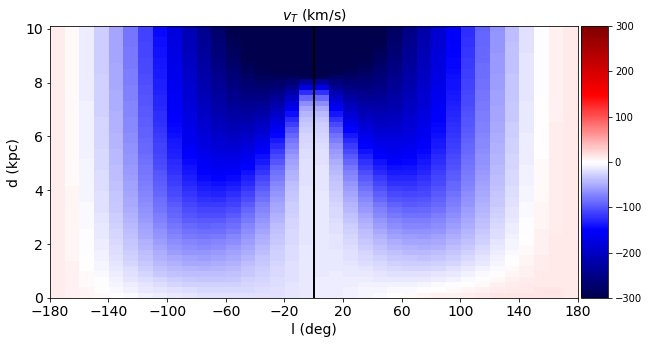

In [83]:
vtl=vtl_lond(lon,d,Us=11.1)
#example of plot for the array of Vtl(lon,d)
vmin=-300.
vmax=300.

plt.figure(figsize=(10,5))
im=plt.imshow(np.flip(vtl.T,axis=0), aspect='auto',extent=[x0-xbin/2., x1+xbin/2., y0-ybin/2, y1+ybin/2]
,interpolation="nearest", origin="upper",cmap='seismic',vmin=vmin,vmax=vmax)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
#ax.axvline(x=0)
ax.axvline(0, lw=2, color="k", ls="solid");
ax.set_xlabel('l (deg)',size=14)
ax.set_ylabel('d (kpc)',size=14)
ax.set_title(r'$v_T$ (km/s)',size=14)
ax.xaxis.set_ticks(np.arange(-180, 180+1, 40.0))
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.show()

## Este és el espacio donde compararemos modelo versus data ("fake observations")

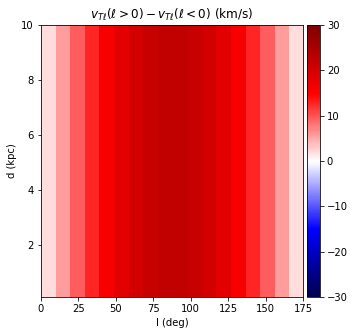

In [84]:
paramo=[11.1]
sym=vtl_lond_sym(paramo)
vmin=-30
vmax=30


plt.figure(figsize=(5,5))
im=plt.imshow(np.flip(sym.T,axis=0), aspect='auto',extent=[0, x1, y0, y1], interpolation="nearest", origin="upper",cmap='seismic',vmin=vmin,vmax=vmax)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('l (deg)')
ax.set_ylabel('d (kpc)')
ax.set_title(r'$v_{T\ell} (\ell>0) - v_{T\ell} (\ell<0)$ (km/s)')
plt.show()

## Empezamos ahora a trabajar con el ABC

In [85]:
import astroabc

## Below we define de funtion for the simulations:

In [86]:

def vtl_lond_sym_abc(param,pool=None):
    Us=param[0]
    vtl=vtl_lond(lon,d,amp=amp,alpha=alpha,vc=vc,Rs=Rs,Z=Z,VZ=VZ,Us=Us,Vs=Vs,Ws=Ws) # Modified by Roger
    if err==True:
        #we add errors increasing as a function of distance:
        mu, sigma = 0.,d.T # mean and standard dev increase as a function of distance
        err2=np.random.normal(mu,sigma)
        vtl=vtl+err2
        #vmin=-30.
        #vmax=30.
        #plt.figure(figsize=(5,5))
        #im=plt.imshow(np.flip(err2.T,axis=0), aspect='auto',extent=[0, x1, y0, y1], interpolation="nearest", origin="upper",cmap='seismic',vmin=vmin,vmax=vmax)
        #ax = plt.gca()
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #plt.colorbar(im, cax=cax)
        #ax.set_xlabel('l (deg)')
        #ax.set_ylabel('d (kpc)')
        #ax.set_title('error added (km/s)')
        #plt.show()
    shape=np.shape(lon)
    Nx=shape[1]
    Ny=shape[0]
    #print(Nx,Ny)
    #print(Us)
    vtl_neg_l=np.flip(vtl[0:int(Nx/2),:],axis=0)
    vtl_pos_l=vtl[int(Nx/2):,:]
    sym=vtl_pos_l-vtl_neg_l
    sym2=np.reshape(sym,918)
    return sym2

## We define below the function of the distance metgric for this specific case

In [87]:
def metric_asymetries(observed,simulated): # Function to compute the distance metric using Chi^2
    
   
    
    nanos=np.count_nonzero(np.isnan(simulated)) # Count the number of bins with nans
    lens=len(simulated)                      
       
    
    if nanos>0.25*lens:  # if more than 25% of the bins have nans assign distance=infinity
        mychisum=float('Inf')
    else:
        mychi=np.nansum(((observed-simulated)/sigma)**2) # Sum of all Chi^2 for each bin                  
        Nbin=lens-nanos                                 # Compute the number of bins without nans
        mychisum=np.sum(mychi)/Nbin                     # Normalization over the number of bins
    #print(mychisum)                       
    return mychisum 

In [88]:
#position of the Sun
Rs=8.178

#define bins in galactic longitude and distance
x0=-175.
x1=175.
y0=0.1
y1=10.
xbin=10.
ybin=0.2
lons=np.arange(x0,x1+xbin,xbin)
ds=np.arange(y0,y1+ybin,ybin)
#convert it to a 2d array
lon,d=np.meshgrid(lons, ds)

# Other Fixed Parameters
amp=0.
alpha=0.
vc=236.
Rs=8.178
Z=0.
VZ=0.
Vs=248.5
Ws=0.
err=False

In [89]:
# usamos una matriz de sigmas con unos (1) solo a model de ejemplo
sigmam=np.ones((18,51))
sigma=np.reshape(sigmam,918)

In [90]:
# Hacemos algunos test para ver que la métrica funciona como deseamos
paramo=[11.1]
data1=vtl_lond_sym(paramo)
data=np.reshape(data1,918)

paramo=[50]
data1=vtl_lond_sym(paramo)
data2=np.reshape(data1,918)

In [91]:
metric_asymetries(data,data2)

3026.4200000000014

In [92]:
metric_asymetries(data,data)

0.0

In [93]:
metric_asymetries(data2,data2)

0.0

In [94]:
model_sim=vtl_lond_sym_abc # definimos quien va a ser la función para hacer las simulaciones

In [95]:
# Definimos quien van a ser "las observaciones". La variable global "data" és la que debe contener las observaciones
paramo=[11.1]
data1=vtl_lond_sym(paramo)
data=np.reshape(data1,918)

### astroABC for python

### Key features

-    Parallel sampling using MPI or multiprocessing
-    MPI communicator can be split so both the sampler, and simulation launched by each particle, can run in parallel

-    A Sequential Monte Carlo sampler (see e.g. Toni et al. 2009, Beaumont et al. 2009, Sisson & Fan 2010)

-    A method for iterative adapting tolerance levels using the qth quantile of the distance for t iterations (Turner & Van Zandt (2012))

-    Scikit-learn covariance matrix estimation using Ledoit-Wolf shrinkage for singular matrices

-    A module for specifying particle covariance using method proposed by Turner & Van Zandt (2012), optimal covariance matrix for a multivariate normal perturbation kernel, local covariance estimate using scikit-learn KDTree method for nearest neighbours (Filippi et al 2013) and a weighted covariance (Beaumont et al 2009)

-    Restart files output frequently so an interrupted run can be resumed at any iteration
-    Output and restart files are backed up every iteration
-    User defined distance metric and simulation methods
-    A class for specifying heterogeneous parameter priors
-    Methods for drawing from any non-standard prior PDF e.g using Planck/WMAP chains
-    A module for specifying a constant, linear, log or exponential tolerance level
-    Well-documented examples and sample scripts


Next we specify priors for each of the parameters we want to vary in the sampler. This is done by specifying a list of tuples. The zeroth element in each tuple should be a string specifying the prior for this parameter and the first element should be a list of the hyperparameters needed for this prior.

In [96]:
priors =  [('uniform', [1., 500.])] # Define the priors por the parameters to explore

Next we need to set some keywords for astroABC. This can be done by creating a dictionary of inputs which are passed to the sampler. Many of these entries have defaults and do not need to be specified explicitly.
Only the name of the distance metric method needs to be explicity provided as a keyword.
The full set of keywords are given in the doc string of the class. Some examples are

- tol_type: which specifies the decreasing tolerance levels. "exp","lin", "log" and "const" are options. (default = 'exp')

- verbose: level of verbosity, 0 = no printout to screen, 1 = print to screen  (default = 0)

- adapt_t: Boolean True/False for adaptive threshold setting (default = False)

- threshold: qth quantile used in adaptive threshold setting (default = 75)

- pert_kernel: 1 =component wise pert. with local diag variance; 2 = multivariate pert. based on local covariance

- variance_method: 0 =weighted covariance, 1= Filippi, 2 = TVZ, 3= Leodoit_Wolf, 4=k-nn (default = 0)

- dfunc:method for calculating the distance metric

- from_restart: Boolean True/False

- restart: string name of restart file

- outfile:string specifying name of output file (default = abc_out.txt)

- mpi: Boolean True/False (default = False)

- mp:Boolean True/False (default = False)

- num_proc:number of threads for mp setting (default = None)

Please see the doc strings of the astroABC sampler for details on each of these settings.

In [97]:
# Define the properties for the astroabc package


prop={ 'dfunc':metric_asymetries,'verbose':1, 'adapt_t': True, 'pert_kernel':2 , 'mp': True, 'num_proc':4}

Now we are ready to create an instance of our sampler. 
To do this we just need to specify the following to the astroabc.ABC_class

astroabc.ABC_class(number of parameters,number of particles,data,tolerance levels,number of iterations,priors,prop)

In [98]:
sampler = astroabc.ABC_class(1,200,data,[1000,0.01],20,priors,**prop)

	 	
	 ########################     astroABC     ########################	
	 	
	 Npart=200 	 numt=20 	 tol=[1000.0000,0.0100] exp
('\t Priors=', [('uniform', [1.0, 500.0])])


In [99]:
sampler.sample(model_sim) # Here we run the ABC algoritm

('\t Step:', 0, '\t tol:', 1000.0, '\t Params:', [16.57132800812104])
('\t Step:', 1, '\t tol:', 281.91371553196905, '\t Params:', [12.560008052523031])
('\t Step:', 2, '\t tol:', 148.13204475714508, '\t Params:', [11.373392555218897])
('\t Step:', 3, '\t tol:', 71.62512195470697, '\t Params:', [10.8035786266791])
('\t Step:', 4, '\t tol:', 34.38981028121057, '\t Params:', [10.825316917399137])
('\t Step:', 5, '\t tol:', 16.594755810167015, '\t Params:', [11.118814051006542])
('\t Step:', 6, '\t tol:', 8.322150347940514, '\t Params:', [11.17164436007367])
('\t Step:', 7, '\t tol:', 4.227843692819042, '\t Params:', [11.096650253875495])
('\t Step:', 8, '\t tol:', 2.3222056850513213, '\t Params:', [11.098019791210397])
('\t Step:', 9, '\t tol:', 1.2295437982343582, '\t Params:', [11.119469749481077])
('\t Step:', 10, '\t tol:', 0.6810231695432055, '\t Params:', [11.125064095327748])
('\t Step:', 11, '\t tol:', 0.3724616692445877, '\t Params:', [11.080388489029769])
('\t Step:', 12, '\t t

# Now we go to plot the results

In [100]:

Us_list=[]
Iang_list=[]
Omep_list=[]
Fipo_list=[]
Distance_list=[]
total_list=[]

with open('abc_out.txt') as ABCresults: # Reading the simulation variables

    for line in ABCresults:
        if not line.startswith("param"): 
            VariableS =line.split()
            Us=float(VariableS[0])  # Assigning the variable X
           
            distance=float(VariableS[1])
            
            Us_list.append(Us)
               
            Distance_list.append(distance)


print(len(Us_list))
  
US=np.array(Us_list).reshape(len(Us_list))    



dataplot=np.matrix(US)
len(dataplot)

3600


1

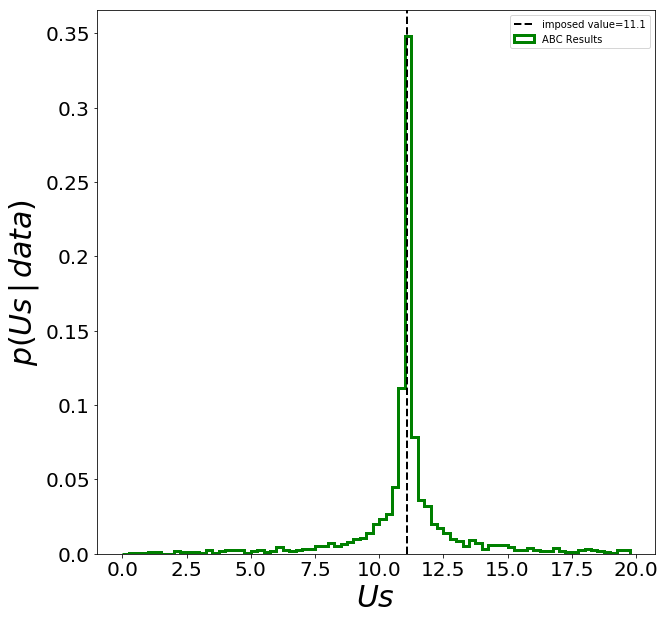

1.0


In [101]:
bins=np.arange(0.00,20,0.25)
plt.figure(figsize=(10,10))
pdf, bins, patches=plt.hist(Us_list,bins=bins, histtype="step", color="green", lw=3, normed=True, label='ABC Results')
plt.xlabel('$\gamma$',fontsize=30)
plt.gca().axvline(11.1, lw=2, color="k", ls="dashed",label="imposed value=11.1");


plt.xlabel('$Us$',fontsize=30)



;
plt.gca().set_yticklabels(np.array([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4])*0.25)
plt.tick_params(labelsize=20)
plt.ylabel("$p(Us\,|\,data)$",size=30)
#plt.xlim(0.0, 0.3)
plt.legend()
plt.show()


print(sum(pdf*0.25))